# Question 1:
The file "series.txt" contains 20 time series, one per column, with values on each line. Perform a principal component analysis on all the series, so as to retain only their projections onto a small set of principal components. Plot the proportion of variance retained on each of the first 5 components. Plot the series associated with the first 3 components in 3D. What do you observe ? Bonus: name this object.

<IPython.core.display.Javascript object>


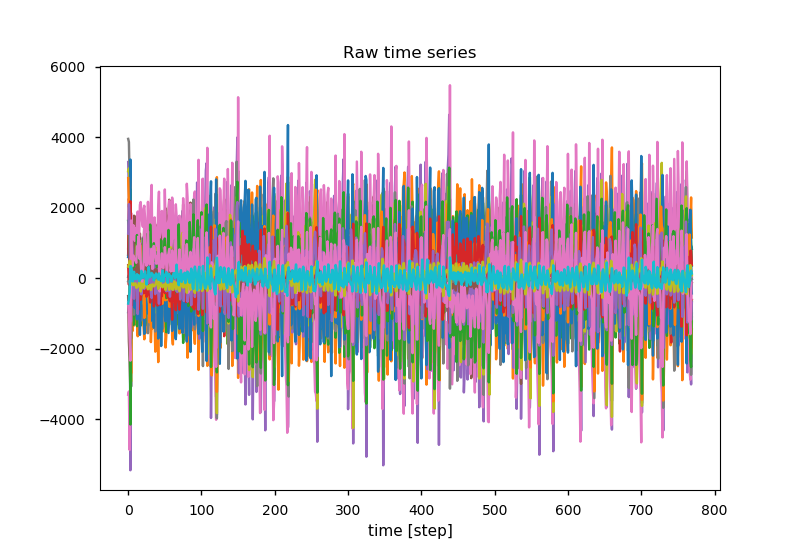

In [13]:
import numpy as np, matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import style; 
style.use('seaborn-notebook')

from sklearn.decomposition import PCA

data = np.loadtxt('question1/series.txt')
pca = PCA(n_components = 5)
assert 20 in data.shape # enforce 20 time-series

fig, ax = plt.subplots()
ax.plot(data)
ax.set(title = 'Raw time series', xlabel = 'time [step]')
fig.show()

/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


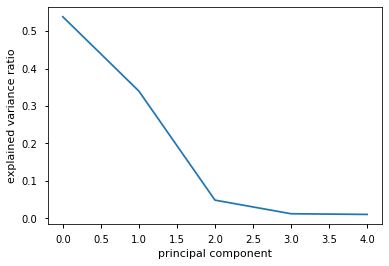

In [2]:
# visualize components
pca.fit(data.T)
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_)
ax.set(xlabel = 'principal component', ylabel = 'explained variance ratio')
# ax.plot(pca.explained_variance_)
fig.show()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


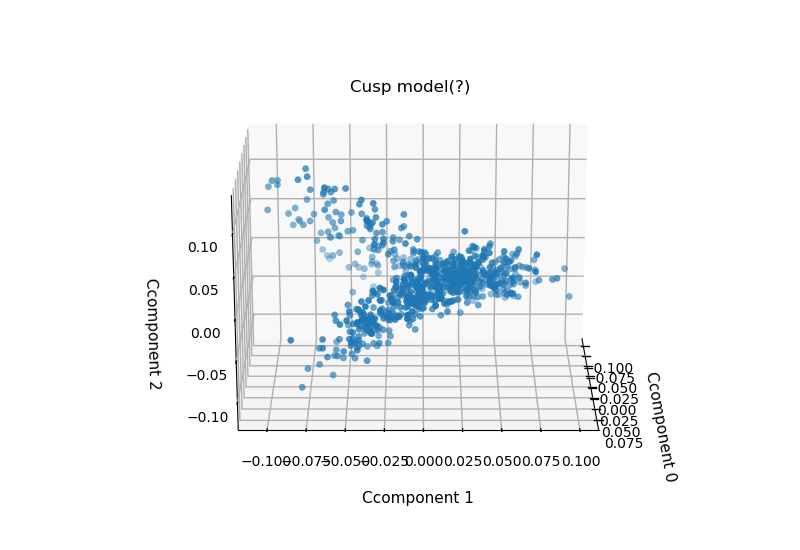

In [3]:
# 3d plot components
%matplotlib
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(subplot_kw = dict(projection = '3d'));
ax.scatter(*pca.components_[:3])

[getattr(ax, f'set_{i}')(f'Ccomponent {idx}', labelpad = 20) \
 for idx, i in enumerate('xlabel ylabel zlabel'.split())]
ax.set(title = 'Cusp model(?)')
ax.view_init(20, 0)
fig.show()

The data looks like a Cusp model (Cusp bifurcation). Namely, looking from the top (component 0 - component 1 view), the data is continuous. Conversely, there is a discontinuous jump when compairing component 1/0 with component 2. This means the data will abruptly change from 1 behavior to a different one when moving in the component 1/0 plane. 

# Question 2: 
Here are two signals, one acquired at 0.5Hz by a temperature sensor inside a volcano fumarole, one produced by a model of steam propagation in the volcano. Plot the power spectrum of each signal, represented as power vs period, for periods between 4s and 15min. Show that the real data has a power peak in a range that you should determine, which is absent in the model. Bonus: an hypothesis for what kind of geophysical process may act at this time scale.


<IPython.core.display.Javascript object>


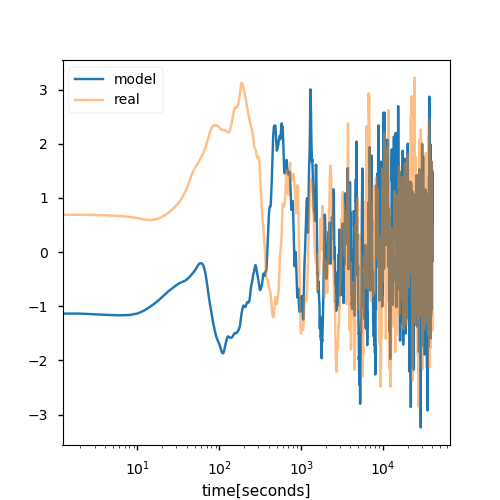

In [4]:
# load the data and get a feel for the temporal dynamics
model_data = np.loadtxt('question2/model.txt')
real_data  = np.loadtxt('question2/signal.txt')
# assert zero mean data [bias offset]
assert np.allclose(model_data.mean(), 0) and np.allclose(real_data.mean(), 0)

# pre-setup based on text
samplingRate = 0.5 # Hz
# create time vector and extract indices of interest
time_points  = np.arange(0, model_data.size) * 1 / samplingRate
# plot raw data
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(time_points, model_data, label = 'model')
ax.plot(time_points, real_data, alpha = .5, label = 'real')
ax.set(xlabel = 'time[seconds]',\
      xscale = 'log',\
      )
ax.legend()
fig.show()

<IPython.core.display.Javascript object>


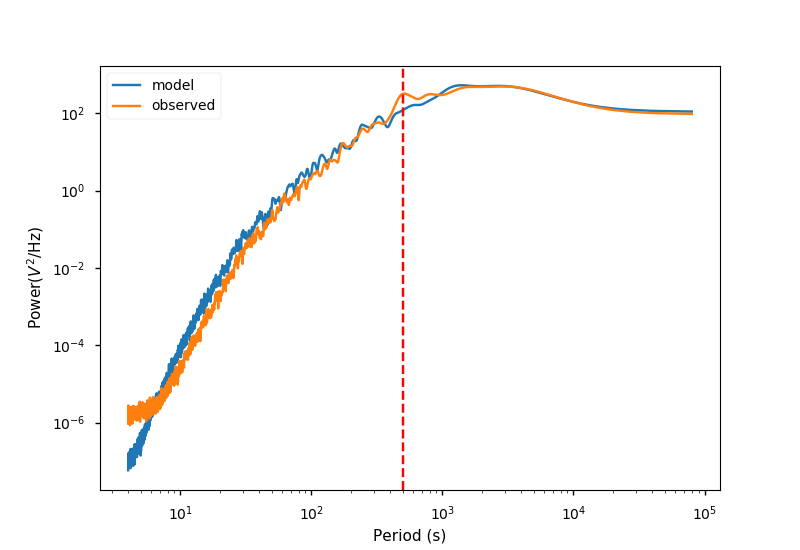

/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [5]:
import scipy.signal, scipy

fig, ax = plt.subplots()


settings = dict(\
               fs      = samplingRate, 
               nperseg = real_data.size // 10, # 10 windows to use
               window  = 'hann', # hanning window
               nfft = 2 * real_data.size, # zero-padding ; note boundary effect will occur
               )
freqs_real, power_real = scipy.signal.welch(real_data, **settings)
freqs_model, power_model = scipy.signal.welch(model_data, **settings)
ax.plot(1/freqs_model, power_model, label = 'model')
ax.plot(1/freqs_real, power_real, label = 'observed')
ax.axvline(5e2, linestyle = 'dashed', color = 'red') # peak?
ax.legend()
ax.set(
    yscale = 'log', \
    xscale = 'log',\
    xlabel = 'Period (s)', ylabel = 'Power($V^2$/Hz)')
fig.show()

There seems to be a peak at around a period of 500 seconds (red line) that is absent in the model. Given the relatively short period of the process, the rise in power would be related to (geophysically) short-time process such as hot water vapor production. This would give rise to the raising of temperature before steam would be actually produced. 

In [6]:
# tried spectrogram analysis but it is very messy
# wanted to know if the steam production occurs before the drop in temperature > model fitted to data?
# spect = scipy.signal.spectrogram(model_data, **settings)
# fig, ax = plt.subplots();
# h = ax.imshow(np.log10(spect[-1].T), aspect = 'auto',\
#           extent = [spect[0].min(), spect[1].max(), spect[0].min(), spect[0].max()]\
#          )
# ax.set(\
#       xscale = 'log')
# fig.colorbar(h, label = 'log(Power)')
# ax.set_xlim(0, 100)

# Question 3
 These two series are generated using stochastic differential equations of the form dX = f(X)dt + g(X)dW. One of these series has a cubic drift as a function of X, the other has a linear drift. Which is which? Assuming one could have infinite precision: for each series, would we see discontinuities (and why)? Bonus: show the drift as a function of X with data analysis.
 

In [7]:
series = np.asarray([np.loadtxt(f'question3/series{i}.txt') for i in '1 2'.split()])

<IPython.core.display.Javascript object>


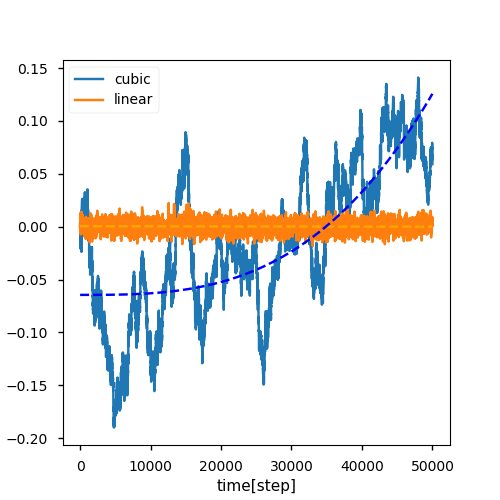

In [8]:
from scipy.optimize import curve_fit

linear_drift = lambda x, a, b: a + b*x
cubic_drift = lambda x, a, b : a + b * (x)**3
x = np.arange(series.shape[1]) # dummy var

opt_cubic = curve_fit(cubic_drift, x, series[0])
opt_linear = curve_fit(linear_drift, x, series[1])

fig, ax = plt.subplots(figsize = (5,5))
ax.plot(series.T)
ax.plot(x, linear_drift(x, *opt_linear[0]), '--', color = 'orange')
ax.plot(x, cubic_drift(x, *opt_cubic[0]), '--b')
ax.legend(labels = ['cubic', 'linear'])
ax.set(xlabel = 'time[step]',\
#       xscale = 'log',\
      )
fig.show()

The provided text implies that there are only 2 options for the curves. Based on the text I pressume the blue line has cubic drift and the orange line has linear drift. Although the drift in general is less pronounced on a non-log scale, the variance of the orange line seems to increase linearly over as a function of $x$. With regards to the blue line I believe a linear curve would also remove the drift fairly well. I will show this using a residual plot and estimating a linear fit on the blue curve. 
## Residual plot

<IPython.core.display.Javascript object>


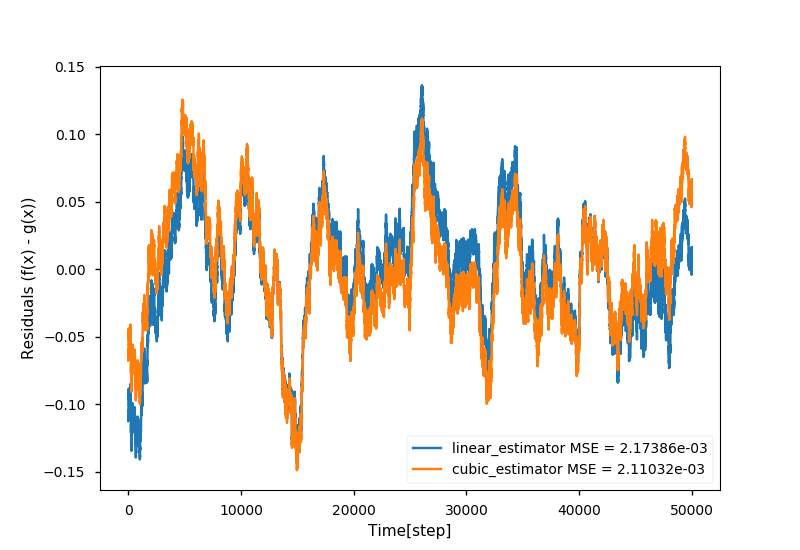

In [9]:
fig, ax = plt.subplots()

linear_fit = curve_fit(linear_drift, x, series[0])
residual_linear = (linear_drift(x, *linear_fit[0]) - series[0])
residual_cubic  = (cubic_drift(x, *opt_cubic[0]) - series[0])
ax.plot(residual_linear)
ax.plot(residual_cubic)

d = dict(\
        linear_estimator = residual_linear,\
         cubic_estimator = residual_cubic\
         )
ax.legend([f'{k} MSE = {(v**2).mean():.5e}' for k, v in d.items()])
ax.set_xlabel('Time[step]')
ax.set_ylabel('Residuals (f(x) - g(x))')
fig.show()

The cubic estimator has slightly less mean square error and as such is preferred as a model since the both linear as well as cubic have the same number of parameter estimated

## Assuming one could have infinite precision: for each series, would we see discontinuities (and why)?

Continuity is a convergence property: a continuous function is one where convergence of the inputs implies convergence of the outputs. For random variables, there can be several kinds of convergence, e.g. convergence in the mean, convergence in probability, convergence in sample paths etc. In order to map the stochastic differential equations (SDs) to the real-world, continuity has to be guaranteed. Specifically, changes in $X$ has to produce continuous paths. In addition it offers nice properties for comparisons between different 

Often a weaker version is assumed called Cadlag, which states that the function is continuous from the right but limited from the left at every point; for every $t_\in T, t \downarrow t_0$ implies $x(t) \rightarrow x(t_0)$ and for $t\uparrow t_0, \lim_{t\uparrow t_0} x(t)$ exists but need not be $x(t_0)$. 

However, for many stochastic processes such as Wiener, there exists continuous paths and therefore we would see no discontinuities.


# Question 4

Complexity and entropy are important concepts for this project. There are many definitions of these and the idea to represent the data in an entropy (H) / complexity (C) plane is not new. References are provided for the "permutation entropy" and the associated complexity measure. In this HC plane, why do the min and max curve join at (0,0) and (1,0)? Give an interpretation for points in each region: near (0,0), near (1,0) and near (intermediate H, Cmax). In order to compute the permutation entropy and complexity, some C++ code is provided, that can be built into a Python module. Documentation is provided in the source code. Use this code in order to compute the entropy and complexity values of the following series, then plot them in the HC plane:
- The projection on the 3 principal components of Question 1.
- The two series of Question 3.
- The signal and the model output of Question 2. For these, use subsamplings from 1 to 30 and plot each point in the HC plane.
Based on the reference papers, what can you say of each for these series ? What is the effect of the subsampling ? Give an explanation why the model and the real signal differ at some point. Bonus: give other definitions of complexity and entropy, which may be better suited depending on the system being studied.



## Interpretation of HC-plane

In complexity science, the "interesting" stuff happens when it deviates from a regular pattern. In this sense both highly structured systems (crystal sturcutres) and highly disordered systems (ideal gas) are considered to be simple and as such a metric should reflect this as having zero complexity. Statistically speaking the amount of disorder in the system will yield an increase in entropy. Rosso et al. (2013) defined a novel statistical metric of complexity as 


\begin{aligned}
C^k_{q, v} &= \underbrace{H^k_q(P)}_{\textrm{Information}} \underbrace{Q_v(P)}_{\textrm{Disequilbrium}}
\end{aligned}


with $H^k$ indicating the normalized entropy = $H^k(P) / I_{\max}$, e.g. Renyi, Shannon *etc*. The fraction of max information bounds the entropy metric between (0, 1): making it more in line with the intuitive expectation of complexity. The level of disequilibrium reflects the architecture of the system. Namely, it reflects how much distance $D$ the system is from $P_e$ (equilibrium distribution, $H_{Shannon}(P_max) = N$ bits). Both information and disequilibrium is needed as the disequilibrium is maximal for the crystaline structure (i.e. it has only one state dominating the state space) but zero for ideal gas (all states equally accessible). Moving from highly ordered systems to disordered systems, we see how the complexity as a function of entropy will be zero at the origin (as entropy approaches zero) and for high entropy (as disequilibrium approaches zero). 

The origin of the HC-plane corresponds to a highly ordered systems that shows now "complex" behavior. Conversely, in the point $(H,C) = (1,0)$ corresponds to a highly disordered system that requires maximal foreknowledge but produces no complex behavior, i.e. it is random and 'regular'. Maximum complexity occurs at intermediate $H$ it can be summarized by the following picture. 

![complex_coffee](complex_coffee.jpg)

It is hard to describe the behavior of the mixing milk, compared to where it is regular. 

## Complexity as a function of order (permutation entropy)

<IPython.core.display.Javascript object>


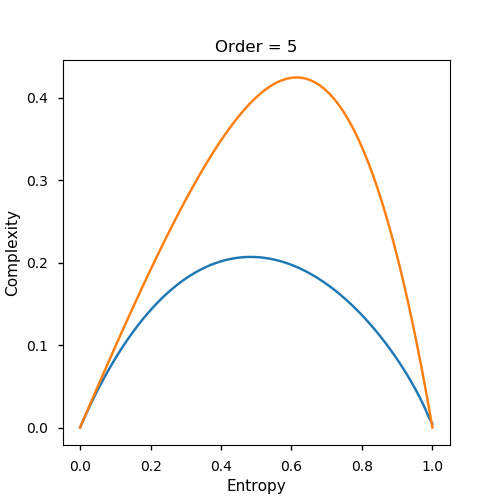

interactive(children=(IntSlider(value=5, description='order', max=20, min=2), Output()), _dom_classes=('widget…

In [10]:
import sys
sys.path.insert(0, 'question4')
import hcpermut
import ipywidgets as widgets
# compute the admissible domain for values of entropy and complexity
hrange = np.linspace(0,1,101)
# Make small applet showing order and complexity    
fig, ax = plt.subplots(figsize = (5,5));
ax.set(xlabel = 'Entropy', ylabel = 'Complexity')
lines = ax.plot(np.random.rand(2, 2).T)
@widgets.interact(order = widgets.IntSlider(min = 2, max = 20, value = 5))
def update(order = 5):
    cminmax = hcpermut.cminmax(hrange, order)
    for line, c in zip(lines, cminmax.T):
        line.set_data(hrange, c)
    ax.set_title(f'Order = {order}')
    ax.relim()
    ax.autoscale_view()
    fig.canvas.flush_events(); fig.canvas.draw()
fig.show()

In [11]:
# compute the permutation entropy and complexity of the data
hc1 = hcpermut.hc(pca.components_[:3].T)
question2Data = np.asarray([model_data, real_data])
hc2       = np.asarray([hcpermut.hc(question2Data[:, ::i].T) for i in range(1, 31)])
hc3       = hcpermut.hc(series.T)

<IPython.core.display.Javascript object>


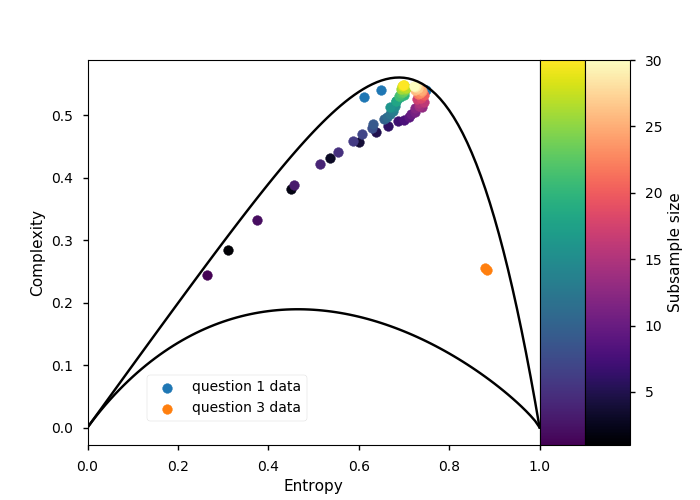

In [12]:
# make complexity plots of data
fig, (ax, tax1, tax2) = plt.subplots(1, 3, figsize = (7,5), gridspec_kw = dict(width_ratios = (1, .1, .1)))
ax.scatter(*hc1.T, label='question 1 data')
ax.scatter(*hc3.T, label = 'question 3 data')
cminmax = hcpermut.cminmax(hrange)
xr = np.linspace(0, 1, len(hc2))
colors_real = plt.cm.viridis(xr)
colors_model = plt.cm.magma(xr)
import matplotlib as mpl
for idx, i in enumerate(hc2):
    ax.scatter(*i[0], color = colors_model[idx])
    ax.scatter(*i[1], color = colors_real[idx])
ax.plot(hrange, cminmax[:, 0], color = 'k') # min complexity 
ax.plot(hrange, cminmax[:, 1], color = 'k') # max complexity

ax.legend( bbox_to_anchor = (.5, 0.2))
ax.set(xlabel = 'Entropy', ylabel = 'Complexity')
norm = mpl.colors.Normalize(vmin = 1, vmax = 30)
cb1 = mpl.colorbar.ColorbarBase(tax1, cmap=plt.cm.viridis,
                                norm=norm,
                                orientation='vertical', ticks = [])
cb2 = mpl.colorbar.ColorbarBase(tax2, cmap = plt.cm.magma, norm = norm, orientation = 'vertical',\
                              label = 'Subsample size')
fig.subplots_adjust(wspace = 0)
ax.set(xlim = (0,1), 
#        ylim = (0, 1), \
#        xscale = 'log', yscale = 'log',\
      )
fig.show()

The first three components seem to be equal in terms of complexity and entropy.
In contrast the data from question 3 scores high in entropy but low in complexity. 

The provided algorithm has an order parameter with default value of n = 7. Note that changing this parameter will result in different results (see min max applet above). As no default was specified, I will use the default of 7. Coarse-graining has the result in increasing the entropy and complexity (near) linearly. However, the observed (real) data increases faster than the model data. Depending on the accuracy of the model, I believe the difference is attributed to the modeling procedure of the steam propagation. Specifically, it probably reduces on the complexity by using some approximation for reality. This yields more entropy but not necessarily more complexity. 

For different definitions of entropy and complexity I am not quite sure what do to with. There are different forms of entropy next to Shannon entropy, for example Renyi, Gibbs or Tsalli entropy. Similarly, for complexity measures there exist a myrida of different measures; some of which are not computable in practice, e.g. Kolmogorov complexity. Complexity metrics can focus on different things. Namely, difficulty of description (entropy-like measures); difficulty of creation (computational complexity or time computational complexity) or degree of organization, e.g. stochastic complexity. With regard to the datasets above; the cusp model would benefit mainly from analysis in the spatial structure of the folds. In contrast the time series of the volcano / SDs would benefit from metrics that focus on detecting change, e.g. fisher information or time shifted mutual information (van Elteren 2019). 